In [42]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 128

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
test_dir = '../data_for_testing/*'

test_list = glob.glob(os.path.join(test_dir, '*.png'))

print(f"Test Data: {len(test_list)}")

Test Data: 2661


In [46]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [47]:
class GWDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        img_transformed = img_transformed[:3, :, :]

        label_str = img_path.split("/")[-1].split("_")[0]
        if label_str == "eccentric":
            label = 1
        elif label_str == "unlensed":
            label = 2
        else:
            label = 0 

        # Extract file number for tracking misclassifications
        file_number = img_path.split("/")[-1].split("_")[1].split('.')[0]

        img_category = img_path.split('/')[2]

        return img_transformed, label, file_number, img_category
    
test_data = GWDataset(test_list, transform=test_transforms)

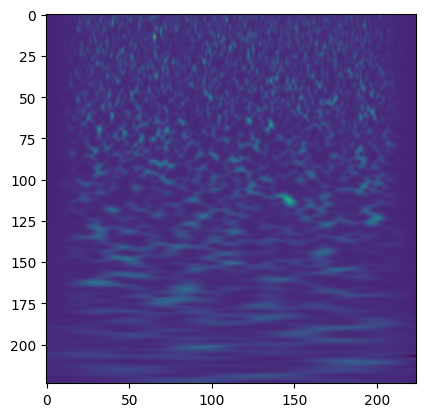

In [48]:
plt.imshow(test_data[2][0].permute(1,2,0))

In [49]:
def custom_collate_fn(batch):
    images, labels, file_numbers, img_category = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels, file_numbers, img_category

test_loader = DataLoader(dataset = test_data, num_workers=os.cpu_count(), batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

In [50]:
a = next(iter(test_loader))

In [51]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN_Model().to(device)

model_path = '../models/cnn_model0.pth'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
else:
    print(f"No pre-trained model found at {model_path}. Please specify a trained model.")


class_names=["Lensed", "Eccentric", "Unlensed"]

Model loaded from ../models/cnn_model0.pth


In [52]:
model.eval()
all_labels = []
all_predictions = []
all_probabilities = []
all_file_numbers = []
all_img_paths = []


with torch.no_grad():
    for data, labels, file_numbers, img_paths in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        all_file_numbers.extend(file_numbers)
        all_img_paths.extend(img_paths)
        
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

misclassified_mask = all_labels != all_predictions
misclassified_indices = np.where(misclassified_mask)[0]

misclassified_info = []
for idx in misclassified_indices:
    info = {
        'file_number': all_file_numbers[idx],
        'file_path': all_img_paths[idx],
        'true_label': all_labels[idx],
        'predicted_label': all_predictions[idx],
        'true_class': class_names[all_labels[idx]],
        'predicted_class': class_names[all_predictions[idx]],
        'prediction_probabilities': all_probabilities[idx]
    }
    misclassified_info.append(info)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, title_suffix="", results_dir=None):
    """
    Plot confusion matrix with counts and percentages, including missing classes.
    """
    try:
        title = title_suffix.split(" Set")[0].split("(")[1]
    except IndexError:
        title = "Confusion_Matrix"

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    row_sums = cm.sum(axis=1, keepdims=True)
    cm_percentage = np.divide(cm, row_sums, where=row_sums != 0) * 100

    annotations = [
        [f"{count}\n({percentage:.1f}%)" if row_sums[i] != 0 else "0\n(0.0%)"
         for j, (count, percentage) in enumerate(zip(cm[i], cm_percentage[i]))]
        for i in range(len(class_names))
    ]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, linewidths=0.5, linecolor='gray')
    plt.title(f'Confusion Matrix{title_suffix}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    if results_dir is not None:
        plt.savefig(results_dir / f'Confusion_Matrix_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

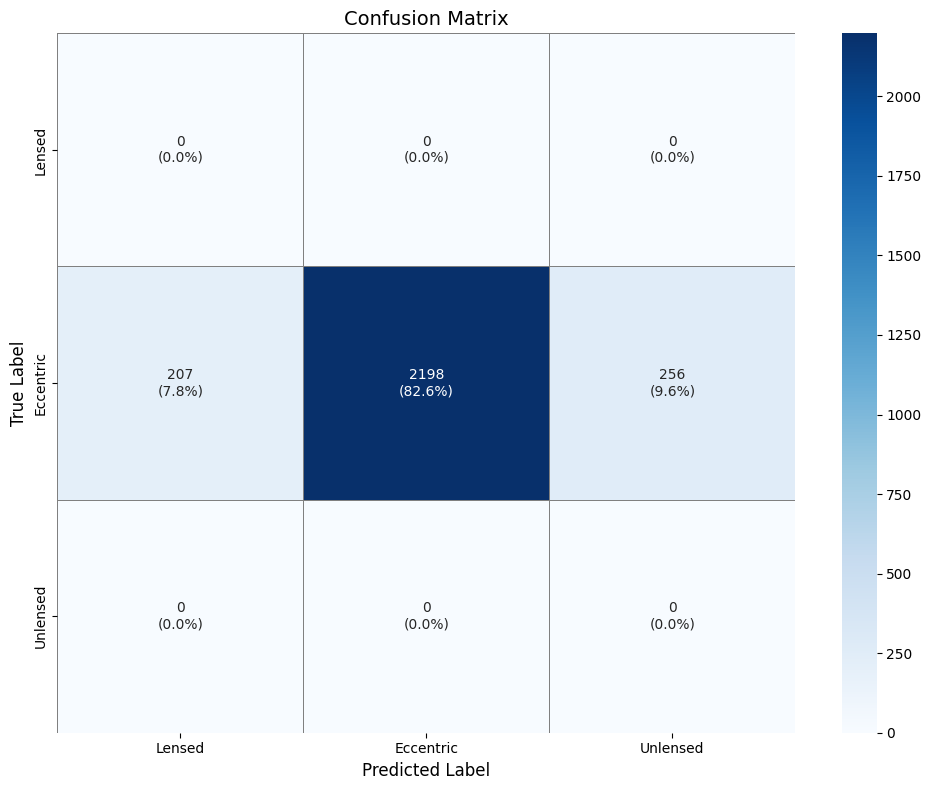

In [54]:
plot_confusion_matrix(all_labels, all_predictions, class_names)

In [55]:
df = pd.DataFrame(misclassified_info)

In [56]:
df

,file_number,file_path,true_label,predicted_label,true_class,predicted_class,prediction_probabilities
0,119,ln_below_10,1,2,Eccentric,Unlensed,"[1.9317852e-06, 0.0019985018, 0.9979996]"
1,155,ln_below_10,1,2,Eccentric,Unlensed,"[1.3784484e-05, 0.023805894, 0.9761804]"
2,209,ln_below_10,1,0,Eccentric,Lensed,"[0.9556881, 0.033975516, 0.0103363395]"
3,173,ln_below_10,1,2,Eccentric,Unlensed,"[0.00012798967, 0.09928175, 0.9005903]"
4,137,ln_below_10,1,2,Eccentric,Unlensed,"[9.481953e-05, 0.014059201, 0.985846]"
...,...,...,...,...,...,...,...
458,836,ln_bw_10_and_30,1,0,Eccentric,Lensed,"[0.99999964, 3.3536637e-07, 3.649498e-15]"
459,968,ln_bw_10_and_30,1,2,Eccentric,Unlensed,"[0.0012491285, 0.0066287806, 0.99212205]"
460,995,ln_bw_10_and_30,1,2,Eccentric,Unlensed,"[0.00023419001, 0.16722511, 0.83254063]"
461,872,ln_bw_10_and_30,1,2,Eccentric,Unlensed,"[5.1923444e-06, 0.040993117, 0.9590018]"


In [57]:
a = np.array(df['file_path'])

In [70]:
ln_below_10_count = 0
ln_bw_10_and_30_count = 0
ln_above_30_count = 0

for i in test_list:
    if i.split("/")[2] == 'ln_below_10':
        ln_below_10_count += 1
    elif i.split("/")[2] == 'ln_bw_10_and_30':
        ln_bw_10_and_30_count += 1
    elif i.split("/")[2] == 'ln_above_30':
        ln_above_30_count += 1 

def count(attribute):
    count = 0
    for i in a:
        if i == attribute:
            count+=1
    if attribute == 'ln_below_10':
        print(f"Out of {ln_below_10_count} number of samples in bin {attribute} {count} were misclassified")
    elif attribute == 'ln_bw_10_and_30':
        print(f"Out of {ln_bw_10_and_30_count} number of samples in bin {attribute} {count} were misclassified")
    else:
        print(f"Out of {ln_above_30_count} number of samples in bin {attribute} {count} were misclassified")

In [71]:
count(attribute='ln_below_10')

Out of 924 number of samples in bin ln_below_10 279 were misclassified


In [72]:
count(attribute='ln_bw_10_and_30')

Out of 745 number of samples in bin ln_bw_10_and_30 132 were misclassified


In [73]:
count(attribute='ln_above_30')

Out of 992 number of samples in bin ln_above_30 52 were misclassified


In [63]:
ln_below_10_count, ln_bw_10_and_30_count, ln_above_30_count

(924, 745, 992)